In [1]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym
from gymnasium import spaces


from typing import Any, Literal
# from pandas import DataFrame



from typing import Any
# from numpy import dtype, floating
from pandas.core.frame import DataFrame
from pandas.core.series import Series



import torch
Tensor = torch.Tensor
import torch.nn as nn
from torch.optim import Adam, RMSprop


In [2]:
from IPython.display  import clear_output 

# %pip install backtrader

clear_output ()

In [3]:
# %matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [5]:

path_m5_xau : str = r"price-values\XAUUSDM5.csv"
path_m15_xau: str = r"price-values\XAUUSDM15.csv"
path_daiy_xau: str = r"price-values\XAUUSDDaily.csv"

path_m5_eur: str = r"price-values\EURUSDM5.csv"
path_m15_eur: str = r"price-values\EURUSDM15.csv"
path_daily_eur: str = r"price-values\EURUSDDaily.csv"


In [6]:
Round = 4
rsi_len = 14
movAvgLen = 5
ma_1 = 10
ma_2 = 20

In [ ]:
df_small = pd.read_csv(path_m5_xau , 
                   encoding = 'utf-16', 
                   names =  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '0'] )

df_small['Date'] = pd.to_datetime(df_small['Date'])
df_small.set_index('Date', drop=True, inplace = True)
df_small.drop('0', axis=1,  inplace = True)

print(df_small.shape)
df_small.head()

(16210, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2025-04-16 01:00:00,3230.96,3231.07,3229.84,3230.80,199
2025-04-16 01:05:00,3230.80,3233.35,3230.68,3231.44,144
2025-04-16 01:10:00,3231.43,3232.56,3231.19,3232.16,139
2025-04-16 01:15:00,3232.15,3232.77,3231.74,3231.74,125
2025-04-16 01:20:00,3231.75,3232.47,3231.47,3232.38,111


In [8]:
df_big = pd.read_csv(path_daiy_xau , 
                   encoding = 'utf-16', 
                   names =  ['Date', 'Open D', 'High D', 'Low D', 'Close D', 'Volume D', '0'] )

df_big['Date'] = pd.to_datetime(df_big['Date'])
df_big.set_index('Date', drop=True, inplace = True)
df_big.drop('0', axis=1,  inplace = True)

print(df_big.shape)
df_big.head()

(359, 5)


,Open D,High D,Low D,Close D,Volume D
Date,,,,,
2024-03-11,2181.21,2189.03,2174.72,2182.65,146453
2024-03-12,2182.17,2184.76,2150.50,2158.13,94467
2024-03-13,2158.00,2179.85,2155.72,2174.32,62440
2024-03-14,2174.54,2176.97,2152.75,2162.19,62755
2024-03-15,2162.32,2172.71,2155.17,2155.82,59222


In [9]:
df_total = pd.concat([df_small, df_big], axis=1)
df_total.fillna(0, inplace = True)
print(df_total.shape)
df_total.tail()

(16569, 10)


,Open,High,Low,Close,Volume,Open D,High D,Low D,Close D,Volume D
Date,,,,,,,,,,
2025-07-24,0.0,0.0,0.0,0.0,0.0,3390.56,3393.35,3351.39,3367.50,80047.0
2025-07-25,0.0,0.0,0.0,0.0,0.0,3369.25,3373.55,3325.08,3336.65,64812.0
2025-07-28,0.0,0.0,0.0,0.0,0.0,3331.05,3345.20,3301.80,3314.78,71500.0
2025-07-29,0.0,0.0,0.0,0.0,0.0,3314.18,3334.14,3307.94,3325.50,70454.0
2025-07-30,0.0,0.0,0.0,0.0,0.0,3327.36,3328.06,3325.98,3328.02,283.0


In [ ]:

def calculate_RSI(data: Series , time_window : int = 14) -> Series:
        delta: Series[type[float]] = data.diff() # type: ignore

        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0 # type: ignore
        down[down > 0] = 0 # type: ignore

        roll_up: Series[float] = up.rolling(time_window).mean()
        roll_down: Series[float] = down.abs().rolling(time_window).mean()

        RS: Series[float] = roll_up / roll_down
        RSI: Series[float] = 100.0 - (100.0 / (1.0 + RS))

        return RSI.round(Round)



def macd(data, fast, slow):
    if isinstance(data, np.ndarray):
        ma1 =  np.convolve(data, np.ones(fast)/fast, mode='valid')
        ma2 =  np.convolve(data, np.ones(slow)/slow, mode='valid')
        return ma2 - ma1
    if isinstance(data, pd.Series):
        ma1 =  data.rolling(fast, min_periods=1).mean()
        ma2 =  data.rolling(slow, min_periods=1).mean()
        return ma2 - ma1



def clc_mean(series : Series , window: int) :
        rolling_mean = series.rolling(window=window).mean().round(Round)
        return  rolling_mean

def moving_avg_std(series : Series , window : int)  -> Series:
    """Calculate the moving average and standard deviation of a pandas series, and then divide the two"""
    rolling_mean = series.rolling(window=window).mean().round(Round)
    rolling_std = series.rolling(window=window).std().round(Round)
    return rolling_mean - rolling_std



In [ ]:
def creat_data(df: pd.DataFrame):
    df['MovAvg'] = df['Close'].rolling(movAvgLen).mean()

    df['diff']  =  (df['Close'] - df['MovAvg']).round(Round) 
    df['cadle-type']  = (df['Close'] - df['Open']).round(Round)
    df['change']  =  df['Open'] - df['MovAvg'] 
    df['macd'] = macd(df['Close'], movAvgLen, movAvgLen*2 )
    df['percent']  =  (df['Close'] - df['Open']) / df['Close']  * 100

    df['rsi']  = calculate_RSI( df['Open'] , rsi_len ) / 100

    df['Pivot'] = (df['High'] + df['Low'] + df['Close']) / 3
    # Optional: First support and resistance
    df['R1'] = (2 * df['Pivot']) - df['Low']
    df['S1'] = (2 * df['Pivot']) - df['High']

    try:
        df['MovAvg D'] = df['Close D'].rolling(movAvgLen).mean()
        df['Pivot D'] = (df['High D'] + df['Low D'] + df['Close D']) / 3
        df['rsi D']  = calculate_RSI( df['Open D'] , rsi_len ) / 100
        df['R1 D'] = (2 * df['Pivot D']) - df['Low D']
        df['S1 D'] = (2 * df['Pivot D']) - df['High D']

    except KeyError as e:
        pass

    # df['buy'] = np.where( (df['Open'] > clc_mean(df['Open'],movAvgLen).shift(1)) & (df['cadle-type'] >= .65), 1 ,0 )

    # df['sell'] = np.where( (df['Open'] < clc_mean(df['Open'],movAvgLen).shift(1)) & (abs(df['cadle-type']) >= .65)  , 1 ,0 )

    # df['hold'] = np.where(df['buy'] == df['sell'], 1, 0)


    df = df.dropna(axis=0)

    return df

In [12]:
df_total.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Open D', 'High D', 'Low D',
       'Close D', 'Volume D'],
      dtype='object')

In [13]:
df_total = df_total[['Open', 'High', 'Low', 'Close', 'Volume', 'Open D', 'High D', 'Low D', 'Close D', 'Volume D']]
df = creat_data(df_total)
df['Volume'] = df['Volume'].astype(np.float64)
df.head(10)

,Open,High,Low,Close,Volume,Open D,High D,Low D,Close D,Volume D,...,percent,rsi,Pivot,R1,S1,MovAvg D,Pivot D,rsi D,R1 D,S1 D
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-16 01:00:00,3230.96,3231.07,3229.84,3230.80,199.0,0.0,0.0,0.0,0.0,0.0,...,-0.004952,1.000000,3230.570000,3231.300000,3230.070000,2604.040,0.0,0.094857,0.0,0.0
2025-04-16 01:05:00,3230.80,3233.35,3230.68,3231.44,144.0,0.0,0.0,0.0,0.0,0.0,...,0.019805,0.999950,3231.823333,3232.966667,3230.296667,1956.534,0.0,0.087532,0.0,0.0
2025-04-16 01:10:00,3231.43,3232.56,3231.19,3232.16,139.0,0.0,0.0,0.0,0.0,0.0,...,0.022586,0.999950,3231.970000,3232.750000,3231.380000,1314.442,0.0,0.078511,0.0,0.0
2025-04-16 01:15:00,3232.15,3232.77,3231.74,3231.74,125.0,0.0,0.0,0.0,0.0,0.0,...,-0.012687,0.999951,3232.083333,3232.426667,3231.396667,668.570,0.0,0.078702,0.0,0.0
2025-04-16 01:20:00,3231.75,3232.47,3231.47,3232.38,111.0,0.0,0.0,0.0,0.0,0.0,...,0.019490,0.999827,3232.106667,3232.743333,3231.743333,0.000,0.0,0.072160,0.0,0.0
2025-04-16 01:25:00,3232.41,3235.25,3232.41,3235.25,132.0,0.0,0.0,0.0,0.0,0.0,...,0.087783,0.999827,3234.303333,3236.196667,3233.356667,0.000,0.0,0.072653,0.0,0.0
2025-04-16 01:30:00,3234.82,3235.99,3234.37,3235.83,288.0,0.0,0.0,0.0,0.0,0.0,...,0.031213,0.999827,3235.396667,3236.423333,3234.803333,0.000,0.0,0.074855,0.0,0.0
2025-04-16 01:35:00,3235.83,3238.90,3235.38,3238.76,222.0,0.0,0.0,0.0,0.0,0.0,...,0.090467,0.999827,3237.680000,3239.980000,3236.460000,0.000,0.0,0.075391,0.0,0.0
2025-04-16 01:40:00,3238.87,3238.87,3236.47,3238.82,223.0,0.0,0.0,0.0,0.0,0.0,...,-0.001544,0.999827,3238.053333,3239.636667,3237.236667,0.000,0.0,0.075393,0.0,0.0


In [14]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=.5)
selector.fit(df)
df_selected = df[df.columns[~selector.get_support(indices=True)]]
df_selected.head()

,S1 D,R1 D,rsi D,Pivot D,MovAvg D,macd,change,cadle-type,diff,MovAvg,Low D,High D,Open D,Volume
Date,,,,,,,,,,,,,,
2025-04-16 01:00:00,0.0,0.0,0.094857,0.0,2604.040,-323.080,2584.800,-0.16,2584.640,646.160,0.0,0.0,0.0,199.0
2025-04-16 01:05:00,0.0,0.0,0.087532,0.0,1956.534,-646.224,1938.352,0.64,1938.992,1292.448,0.0,0.0,0.0,144.0
2025-04-16 01:10:00,0.0,0.0,0.078511,0.0,1314.442,-969.440,1292.550,0.73,1293.280,1938.880,0.0,0.0,0.0,139.0
2025-04-16 01:15:00,0.0,0.0,0.078702,0.0,668.570,-1292.614,646.922,-0.41,646.512,2585.228,0.0,0.0,0.0,125.0
2025-04-16 01:20:00,0.0,0.0,0.072160,0.0,0.000,-1615.852,0.046,0.63,0.676,3231.704,0.0,0.0,0.0,111.0


In [15]:
df_selected.columns

Index(['S1 D', 'R1 D', 'rsi D', 'Pivot D', 'MovAvg D', 'macd', 'change',
       'cadle-type', 'diff', 'MovAvg', 'Low D', 'High D', 'Open D', 'Volume'],
      dtype='object')

In [ ]:
data = df[
                [	'Open', 'High', 'Low' , 'Close', 'Volume',
                    'macd',
                    'Pivot D',  "R1 D", 'S1 D', 'MovAvg D'
                ]
                    ]
data.head(10)

,Open,High,Low,Close,Volume,macd,Pivot D,R1 D,S1 D,MovAvg D
Date,,,,,,,,,,
2025-04-16 01:00:00,3230.96,3231.07,3229.84,3230.80,199.0,-323.080,0.0,0.0,0.0,2604.040
2025-04-16 01:05:00,3230.80,3233.35,3230.68,3231.44,144.0,-646.224,0.0,0.0,0.0,1956.534
2025-04-16 01:10:00,3231.43,3232.56,3231.19,3232.16,139.0,-969.440,0.0,0.0,0.0,1314.442
2025-04-16 01:15:00,3232.15,3232.77,3231.74,3231.74,125.0,-1292.614,0.0,0.0,0.0,668.570
2025-04-16 01:20:00,3231.75,3232.47,3231.47,3232.38,111.0,-1615.852,0.0,0.0,0.0,0.000
2025-04-16 01:25:00,3232.41,3235.25,3232.41,3235.25,132.0,-1293.217,0.0,0.0,0.0,0.000
2025-04-16 01:30:00,3234.82,3235.99,3234.37,3235.83,288.0,-970.512,0.0,0.0,0.0,0.000
2025-04-16 01:35:00,3235.83,3238.90,3235.38,3238.76,222.0,-647.956,0.0,0.0,0.0,0.000
2025-04-16 01:40:00,3238.87,3238.87,3236.47,3238.82,223.0,-325.490,0.0,0.0,0.0,0.000


In [ ]:

from typing import Any
from numpy import floating
import torch.nn.functional as F


class MarketEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, 
                 df: pd.DataFrame, 
                 win_size: int, 
                 sharpe_weight : float = .4,
                 shapre_compression : int = 5,
                 size : float = 0.01 ,
                 transaction_cost : float = 1e-2,
                 portfolio : float = 100,
                 risk_free_rate : float = 1e-2):
        super().__init__()
        self.df = df.reset_index(drop=True).astype(np.float32)
        self.win_size = win_size
        self.num_features = df.shape[1]
        self.current_step = self.win_size
        self.max_steps = len(df) - win_size - 1
        self.step_count : int = 0
        self.current_position : int = 0
        self.reward : float = 0.
        self.risk_free_rate: float = risk_free_rate
        self.trade_record: list[tuple[int, float]] = list()
        self.pnl : float = 0.
        self.sharpe_reward : float = 0.
        self.portfolio_Start = portfolio
        self.portfolio = portfolio
        self.size = size
        self.commission = transaction_cost
        self.sharpe_weight = sharpe_weight
        self.shapre_compression = shapre_compression
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(win_size, self.num_features),
            dtype=np.float32
        )
        self.state : np.ndarray

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.win_size
        self.step_count = 0
        self.current_position = 0
        self.state = self._get_observation()
        self.trade_record.clear()
        self.pnl : float = 0.
        self.sharpe_reward : float = 0.
        self.portfolio = self.portfolio_Start
        return self.state, {}


    def _get_observation(self):
        window = self.df.iloc[max(0, self.current_step - self.win_size): self.current_step].to_numpy()
        window_tensor = torch.tensor(window, dtype=torch.float32)

        # اگر ردیف‌ها کمتر از win_size بودن، باید zero-padding کنیم
        if window_tensor.shape[0] < self.win_size:
            pad_rows = self.win_size - window_tensor.shape[0]
            # pad last dim with 0s: (left, right, top, bottom)
            padding = (0, 0, pad_rows, 0)  # پد در بالا
            window_tensor = F.pad(window_tensor, padding, "constant", 0)

        return window_tensor.numpy()


    def _calc_pnl(self, prices: np.ndarray , action : int ) -> float:

        transaction_cost = (prices.sum()  *  self.size ) * self.commission

        return (prices * action *  self.size ) - transaction_cost

    def _calc_shapre(self):
        if len(self.trade_record) < 2:
            return 0.0  # جلوگیری از تقسیم بر صفر
        # print(self.trade_record[-self.shapre_compression:])
        excess_returns: np.ndarray = np.array(self.trade_record[-self.shapre_compression:]) - self.risk_free_rate
        mean_excess_return: floating[Any] = np.mean(excess_returns)
        std_excess_return: floating[Any] = np.std(excess_returns)
        
        if std_excess_return == 0:
            return 0.0
        
        sharpe: floating[Any] = mean_excess_return / std_excess_return
        return sharpe * np.sum(excess_returns)  


    def step(self, action : int, margin : float = 0.):

        # action += 1
        match action:
            case  0:
                real_action = 1  # Buy
            case 1:
                real_action = -1 # Sell
            case 2:
                real_action = 0  # Hold
        # State:
        # O: 0 | H: 1 | L: 2 | C: 3 | V: 4 | 
        # print(f'state {self.state[:,5].sum()}')
        chnages = self.state[:,0][0] - self.state[:,0][1]
        # print(chnages)
        self.pnl = self._calc_pnl(chnages , real_action )
        self.trade_record.append(( action ,self.pnl))
        
        self.sharpe_reward = self._calc_shapre()

        self.reward = ((1 - self.sharpe_weight) * self.pnl) + (self.sharpe_weight * self.sharpe_reward)
 
        self.current_step += 1
        self.step_count += 1
        self.current_position = action # type: ignore
        terminated: bool = False
        truncated: bool = self.step_count >= self.max_steps
        self.state = self._get_observation()
        self.portfolio += self.pnl

        info = {}
        return self.state, self.reward , terminated, truncated, info

    def render(self, mode="human"):
        print(f"Step: {self.step_count}, Reward: {self.reward:.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, win_size , n_feature):
        super().__init__()

        self.norm_all = nn.LayerNorm(n_feature)
        
        self.i_know = nn.LSTM(input_size=n_feature, 
                        hidden_size=n_feature,
                          num_layers= 128,
                          batch_first=True,
                          bidirectional= False
                          )
        

        
        self.i_see = nn.Sequential(
            nn.Conv1d(in_channels=win_size, out_channels=win_size, kernel_size=7, padding='same'),
            nn.BatchNorm1d(win_size),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=win_size, out_channels=win_size, kernel_size=5, padding='same'),
            nn.BatchNorm1d(win_size),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=win_size, out_channels=win_size, kernel_size=3, padding='same'),
            nn.BatchNorm1d(win_size),
            nn.LeakyReLU()
            )

        self.i_decide = nn.Sequential(
            nn.Flatten(),
            nn.Linear(win_size * n_feature, 1024), 
            nn.Dropout(.5),
            nn.LeakyReLU(),
            nn.Linear(1024, 512), 
            nn.LeakyReLU(),
            nn.Linear(512, 128), 
            # -------------------------------------
            nn.Linear(128, 812), # fc1
            nn.Dropout(.5),
            nn.LeakyReLU(),
            nn.Linear(812, 128), # fc2
            nn.LeakyReLU(),
            nn.Linear(128, 3), # out
    
        )


    def forward(self, X: Tensor) -> Tensor:
        # print(X.shape)
        x : Tensor = self.norm_all(X).unsqueeze(0)

        iknow : Tensor
        iknow ,_ = self.i_know(x)

        isee : Tensor = self.i_see(iknow)
        
        whathpend =  isee + iknow.tanh()

        out = self.i_decide(whathpend)

        return out




# تبدیل observation به بردار 1D برای ورودی شبکه
def preprocess_obs(obs : np.ndarray | Tensor) -> torch.Tensor:
    return torch.tensor(obs, dtype=torch.float32)


In [19]:
assert not data.isnull().any().any(), "NaN exists in dataframe!"

data.describe()

,Open,High,Low,Close,Volume,macd,Pivot D,R1 D,S1 D,MovAvg D
count,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.0,840.0,840.0,840.000000
mean,3323.838036,3325.596250,3322.197643,3323.899774,240.135714,-33.136668,0.0,0.0,0.0,194.572993
std,52.455272,52.490233,52.344706,52.357119,112.758713,281.903422,0.0,0.0,0.0,318.888023
min,3178.390000,3181.170000,3177.740000,3180.650000,65.000000,-1615.852000,0.0,0.0,0.0,0.000000
25%,3299.725000,3301.755000,3298.045000,3300.735000,163.000000,-331.172500,0.0,0.0,0.0,0.000000
50%,3325.390000,3327.090000,3324.030000,3325.385000,220.000000,-0.475500,0.0,0.0,0.0,0.000000
75%,3358.880000,3360.312500,3357.657500,3359.030000,292.250000,323.723000,0.0,0.0,0.0,649.996000
max,3450.660000,3451.220000,3448.140000,3450.530000,1181.000000,358.094000,0.0,0.0,0.0,2604.040000


In [ ]:
from torch.distributions import Categorical

class SimpleRLAgent:
    def __init__(self, win_size, num_features ,action_dim):
        self.policy = PolicyNetwork (win_size=win_size, n_feature=num_features )
        self.policy.to(device)
        self.optimizer = optim.RMSprop(self.policy.parameters(), lr=0.01)
        self.buffer = []  # Stores (log_prob, reward) pairs
    
    def select_action(self, state):
        state = torch.FloatTensor(state).to(device)#.unsqueeze(0)
        logits = self.policy(state)
        probs: Tensor = F.softmax(logits, dim=-1)  # Convert logits to probabilities
        
        m = Categorical(probs)
        action = m.sample().squeeze(0)

        log_prob: Tensor = m.log_prob(action) 
        
        return action, log_prob
    
    def update(self):
        if not self.buffer:
            return
        
        # Extract stored (log_prob, reward) pairs
        log_probs, rewards = zip(*self.buffer)
        log_probs = torch.stack(log_probs).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        
        # Normalize rewards (reduces variance)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
        
        # Policy gradient loss: -log_prob * reward (maximize reward)
        loss = (-log_probs * rewards).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.buffer = []  # Clear buffer after update
        return loss.item()

In [21]:
torch.autograd.set_detect_anomaly(True)


In [22]:
data.shape

(840, 10)

In [45]:

window_size = 5

env = MarketEnv(df=data, 
                win_size=window_size,
                risk_free_rate = 1e-1 ,
                sharpe_weight = .7 ,
                shapre_compression= 5,
                size= 0.01,
                transaction_cost = 2e-2,

               )
obs, _ = env.reset()

# actor: PolicyNetwork   = PolicyNetwork (win_size=window_size, n_feature=env.num_features )


agent = SimpleRLAgent(win_size=window_size, 
                      num_features=env.num_features, 
                      action_dim=3)  # 3 discrete actions

# optim = optim.Adam(actor.parameters(), lr=1e-3, maximize=True)

num_episodes = 10
max_steps = 1_00
reward_to_episodes = list()
done : bool = False
gain_over_episode = list()

for episode in range(num_episodes):
    state ,_= env.reset()
    episode_reward = 0.
    
    # while not done:
    for step in range(max_steps):
        action, log_prob = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action.detach().cpu()) # type: ignore
        agent.buffer.append((log_prob, reward))
        
        state = next_state
        episode_reward += reward
        done: bool = terminated or truncated
        # env.render()
        # if done:
    agent.update()  # Update policy at the end of the episode
    gain_over_episode.append(env.portfolio)
    print(f"Episode {episode+1} | Reward {episode_reward:.4f} | Gain {env.portfolio:.4f}")
    reward_to_episodes.append(episode_reward)





Episode 1 | Reward 167.2094 | Gain 101.8694839477539

Episode 2 | Reward 159.6402 | Gain 100.81414794921875

Episode 3 | Reward 187.7560 | Gain 101.40437316894531

Episode 4 | Reward 155.8537 | Gain 99.01179504394531

Episode 5 | Reward 150.3257 | Gain 100.62007141113281

Episode 6 | Reward 173.9911 | Gain 100.74678802490234

Episode 7 | Reward 175.1210 | Gain 99.43189239501953

Episode 8 | Reward 174.7441 | Gain 103.41475677490234

Episode 9 | Reward 181.7471 | Gain 98.50969696044922

Episode 10 | Reward 115.6423 | Gain 99.43329620361328



In [46]:
params = torch.tensor(0.0)

for name, param in agent.policy.named_parameters():
    params += param.size().numel()
    # print(name, param.size(),)

params

tensor(1087855.)

In [47]:
final_portfolio = env.portfolio
max_drawup = np.max(env.trade_record)
max_drawdown = np.min(env.trade_record)
mean_record = np.mean(env.trade_record)
std_record = np.std(env.trade_record) 
median_record = np.median(env.trade_record)



print(f"""
portfolio   {final_portfolio : .4f}
max gain    {max_drawup  :.4f}
min gain    {max_drawdown  :.4f}
mean gain   {mean_record  :.4f}
std gain   {std_record :.4f}
median gain {median_record  :.4f}
""")


portfolio    99.4333
max gain    2.0000
min gain    -1.0093
mean gain   0.4172
std gain   0.7212
median gain 0.0005



In [48]:
import seaborn as sns

sns.lineplot({"reward": reward_to_episodes})
plt.title("total reward for each episode")
plt.xlabel('Episodes')
plt.ylabel("Rewards")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>

In [49]:
sns.lineplot({"Record": np.array(env.trade_record)[:,1] } )
plt.title("total Record")
plt.xlabel('Position')
plt.ylabel("gain")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>

In [50]:
sns.lineplot({"gains": gain_over_episode } )
plt.title("total Record")
plt.xlabel('Position')
plt.ylabel("gain")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>

In [51]:
n_features = env.num_features
n_rows = data.shape[0]
usable_rows = (n_rows // window_size) * window_size
data_trimmed = data.iloc[:usable_rows, :]

data_tensor = torch.tensor(data_trimmed.to_numpy(), dtype=torch.float).reshape(-1, window_size, n_features).to(device)
print(data_tensor.shape)

torch.Size([167, 5, 14])


In [52]:
print(data_tensor.shape, data.shape)

torch.Size([167, 5, 14]) (835, 14)


In [53]:

labels = []
with torch.no_grad():
    agent.policy.eval()
    for state in data_tensor:
        probs  = F.softmax(agent.policy(state), dim=-1) # type: ignore
        m = Categorical(probs)
        action = m.sample().squeeze(0).item()
        labels.append(action)

tensor_labels = torch.tensor(labels)
# print(tensor_labels)
# print(action)

In [54]:
print(f"""
uniques {torch.unique(tensor_labels, return_counts=True)}
labels.shape {tensor_labels.shape} 
data_tensor.shape {data_tensor.shape}
data.shape {data.shape} """)


uniques (tensor([0, 1, 2]), tensor([47, 63, 57]))
labels.shape torch.Size([167]) 
data_tensor.shape torch.Size([167, 5, 14])
data.shape (835, 14) 


In [55]:

trade_df = data.copy()
labels_full = [2] * len(trade_df)  # مقدار پیش‌فرض برای همه ردیف‌ها

# تعداد ردیف‌هایی که برای مدل استفاده شدن
usable_rows = (len(df) // window_size) * window_size

for i, label in enumerate(tensor_labels):
    idx = i * window_size
    if idx < len(labels_full):
        labels_full[idx] = label.item()   # type: ignore
        # the rest all `2`

data['signal'] = labels_full


data.head()


,Open,High,Low,Close,Volume,macd,Pivot D,R1 D,S1 D,MovAvg D,signal,shifted,true-diff,true-signal
Date,,,,,,,,,,,,,,
2025-04-16 01:25:00,3232.41,3235.25,3232.41,3235.25,132.0,-1293.217,0.0,0.0,0.0,0.0,2,3230.80,4.45,0
2025-04-16 01:30:00,3234.82,3235.99,3234.37,3235.83,288.0,-970.512,0.0,0.0,0.0,0.0,2,3231.44,4.39,0
2025-04-16 01:35:00,3235.83,3238.90,3235.38,3238.76,222.0,-647.956,0.0,0.0,0.0,0.0,2,3232.16,6.60,0
2025-04-16 01:40:00,3238.87,3238.87,3236.47,3238.82,223.0,-325.490,0.0,0.0,0.0,0.0,2,3231.74,7.08,0
2025-04-16 01:45:00,3238.76,3239.28,3237.48,3238.72,230.0,-2.886,0.0,0.0,0.0,0.0,2,3232.38,6.34,0


In [56]:
data['shifted'] = data['Close'].shift(5)#.mean()
data['true-diff'] = data['Close'] - data['shifted']

data['true-signal'] = 2  # default
data.loc[data['shifted'] <= data['Close'], 'true-signal'] = 0
data.loc[data['shifted'] >= data['Close'], 'true-signal'] = 1

data.dropna(inplace=True)
fliterd_data = data[['Close', 'shifted', 'true-diff', 'signal', 'true-signal']]

# fliterd_data = fliterd_data[(fliterd_data['true-signal'] == fliterd_data['signal']) ]

fliterd_data.sample(5)

,Close,shifted,true-diff,signal,true-signal
Date,,,,,
2025-06-23 01:30:00,3376.60,3381.27,-4.67,2,1
2025-04-23 02:05:00,3340.02,3332.23,7.79,2,0
2025-06-25 01:35:00,3321.25,3322.96,-1.71,2,1
2025-06-30 01:35:00,3261.70,3265.77,-4.07,2,1
2025-05-26 01:25:00,3343.38,3351.67,-8.29,2,1


In [57]:
accuracy = (data['true-signal'] == data['signal']).mean()

from sklearn.metrics import classification_report


report = classification_report(data['true-signal'], data['signal'], target_names = ['Buy', 'Sell', 'Hold'])

print(f"""
accuracy {accuracy:.4%}
report
{report}
""")


accuracy 5.7831%
report
              precision    recall  f1-score   support

         Buy       0.45      0.05      0.09       405
        Sell       0.43      0.06      0.11       425
        Hold       0.00      0.00      0.00         0

    accuracy                           0.06       830
   macro avg       0.29      0.04      0.07       830
weighted avg       0.44      0.06      0.10       830




In [58]:
np.unique(data['signal'].to_numpy(), return_counts = True)

(array([0, 1, 2]), array([ 47,  63, 720]))

In [59]:
# from IPython.display import clear_output 
# %pip install backtrader
# clear_output ()

In [60]:
import backtrader as bt

# 1. Define a custom Pandas feed with signal line
class PandasSignalData(bt.feeds.PandasData):
    lines = ('signal',)  # add 'signal' column
    params = (('signal', -4),
                                       ('R1', -7),
                                       ('S1', -6),

           )  # tell backtrader where to find it (column index or name)


In [68]:
class TestStrategy(bt.Strategy):
    params = dict(
        value_type = False,
        tp_percent= .01 ,  # 5% take profit for buy
        sl_percent= .01 ,  # 2% stop loss for buy
        tp_value = 5 ,  # 5% take profit for sell
        sl_value = 5, #mean_record + std_record ,  # 2% stop loss for sell
        max_hold= None ,    # maximum candle to hold on a position
        size = 0.01 
    )

    def __init__(self):
        self.signal = self.datas[0].signal
        self.entry_price = None
        self.bar_executed = None
        self.position_type = None  # 'long' یا 'short'
        self.size = 0.1

    def next(self):
        price_now = self.data.close[0]

        if not self.position:
            if self.signal[0] == 0:
                # if not self.position_type in ('short', None):
                self.close()
                self.entry_price = price_now
                self.buy(exectype= bt.Order.Market,
                            size= self.size,
                            # tp = self.entry_price + self.p.tp_value , #* (1 + self.p.tp_percent),
                            # sl = self.entry_price - self.p.sl_value #* (1 - self.p.sl_percent)
                            )
                self.bar_executed = len(self)
                self.position_type = 'long'

            elif self.signal[0] == 1:
                # if not self.position_type in ('long', None):
                self.close()
                self.entry_price = price_now
                self.sell(exectype= bt.Order.Market,
                            size= self.size,
                            # tp = self.entry_price - self.p.tp_value ,#* (1 - self.p.tp_percent),
                            # sl = self.entry_price + self.p.sl_value #* (1 + self.p.sl_percent)
                            )
                self.entry_price = price_now
                self.bar_executed = len(self)
                self.position_type = 'short'

        else:
            pass
            if self.position_type == 'long':
                # value
                if self.p.value_type:
                    tp_price = self.entry_price + self.p.tp_value 
                    sl_price = self.entry_price - self.p.sl_value 
                # Percentage
                else:
                    tp_price = self.entry_price * (1 + self.p.tp_percent)
                    sl_price = self.entry_price * (1 - self.p.sl_percent)
                
                
                if price_now >= tp_price:
                    self.close()
                    # print(f"Take Profit (long) hit at {price_now}")
                    self.position_type = None
                    self.entry_price = None
                    self.bar_executed = None

                elif price_now <= sl_price:
                    self.close()
                    # print(f"Stop Loss (long) hit at {price_now}")
                    self.position_type = None
                    self.entry_price = None
                    self.bar_executed = None

            # پوزیشن شورت
            elif self.position_type == 'short':
                # value
                if self.p.value_type:
                    tp_price = self.entry_price - self.p.tp_value 
                    sl_price = self.entry_price + self.p.sl_value 
                # Percentage
                else:
                    tp_price = self.entry_price * (1 - self.p.tp_percent)
                    sl_price = self.entry_price * (1 + self.p.sl_percent)


                if price_now <= tp_price:
                    self.close()
                    # print(f"Take Profit (short) hit at {price_now}")
                    self.position_type = None
                    self.entry_price = None
                    self.bar_executed = None

                elif price_now >= sl_price:
                    self.close()
                    # print(f"Stop Loss (short) hit at {price_now}")
                    self.position_type = None
                    self.entry_price = None
                    self.bar_executed = None

            # شرط زمانی خروج از هر نوع پوزیشن
            if not self.p.max_hold == None:
                if self.bar_executed and (len(self) - self.bar_executed) >= self.p.max_hold:
                    self.close()
                    # print(f"Time-based exit at {price_now}")
                    self.position_type = None
                    self.entry_price = None
                    self.bar_executed = None




In [69]:
data = data[['Open', "High", "Low",  "Close", "Volume", "signal"]]

In [70]:
# 4. Feed into backtrader
trade_data = PandasSignalData(dataname=data) # type: ignore



cerebro = bt.Cerebro()
cerebro.adddata(trade_data)
cerebro.addstrategy(TestStrategy)
cerebro.broker.setcash(10_000)
cerebro.broker
cerebro.addanalyzer(bt.analyzers.SharpeRatio,
                     _name='sharpe', 
                     timeframe=bt.TimeFrame.Days,  # type: ignore
                    #  riskfreerate = 1e-1, 
                    #  compression = 5
                     )
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.broker.set_shortcash(True)


results = cerebro.run()
strategy = results[0]

trade_values = pd.DataFrame(
    {"Starting Value" :[cerebro.broker.startingcash],
     "Final Value": [cerebro.broker._valuelever],
     "gross" : [cerebro.broker._valuelever - cerebro.broker.startingcash],
     "Peak" : [cerebro.broker.cash],
}, index = ['value']).T

print(trade_values)

                    value
Starting Value  10000.000
Final Value     10002.230
gross               2.230
Peak            10332.436


In [71]:
sharpe = strategy .analyzers.sharpe.get_analysis()
drawdown = strategy .analyzers.drawdown.get_analysis()

trades = strategy .analyzers.trades.get_analysis()
returns = strategy .analyzers.returns.get_analysis()


BuyOrders = len(list(filter(lambda x : type(x).__name__ == 'BuyOrder' , strategy._orders)) )
SellOrders = len(list(filter(lambda x : type(x).__name__ == 'SellOrder' , strategy._orders)) )


In [72]:

trade_stats = {
    "Buy Orders": [BuyOrders],
    "Sell Orders": [SellOrders],
    "Total Orders": [BuyOrders + SellOrders],
    '-': ['-'*13],
    "Sharpe Ratio": [round(sharpe.get('sharperatio', float('nan')), 4)],
    "Max Drawdown (%)": [round(drawdown.max.drawdown, 2)],
    "Total Net Profit (%)": [round(returns['rtot'] * 100, 2)],
    "Win Rate (%)": [round(trades['won']['total'] / trades['total']['total'] * 100, 2)]
}

df = pd.DataFrame(trade_stats, index = ['value']).T
print(df)



                              value
Buy Orders                       81
Sell Orders                      84
Total Orders                    165
-                     -------------
Sharpe Ratio                -0.0838
Max Drawdown (%)               0.39
Total Net Profit (%)           0.02
Win Rate (%)                  46.43


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

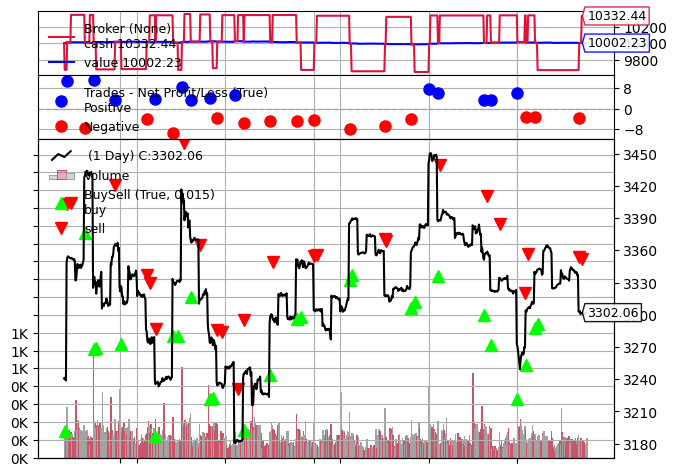

In [73]:
fig = plt.figure(figsize=(100,100))

cerebro.plot(
            # width = 100, 
            # height = 50, 
            dpi=500,
            iplot= True,
            )[0][0] # type: ignore